<a href="https://colab.research.google.com/github/VictoorV/catdog/blob/main/catdogsv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rawaffahadnafea/cats-and-dogs-dataset-cvproject")

print("Path to dataset files:", path)

100%|██████████| 137M/137M [00:07<00:00, 18.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rawaffahadnafea/cats-and-dogs-dataset-cvproject/versions/1


In [2]:
path = '/root/.cache/kagglehub/datasets/rawaffahadnafea/cats-and-dogs-dataset-cvproject/versions/1/dataset'

In [3]:
pip install timm

In [4]:
pip install torchinfo

In [5]:
import os
import matplotlib.pyplot as plt
import timm
from PIL import Image, ImageFilter
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToPILImage, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, random_split, Dataset
import torch
from torchvision import models
from torch import nn, optim
from torchinfo import summary
from sklearn.metrics import classification_report
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Données

In [ ]:
print(path)
!ls /root/.cache/kagglehub/datasets/rawaffahadnafea/cats-and-dogs-dataset-cvproject/versions/1/dataset

/root/.cache/kagglehub/datasets/rawaffahadnafea/cats-and-dogs-dataset-cvproject/versions/1/dataset
test_set  training_set


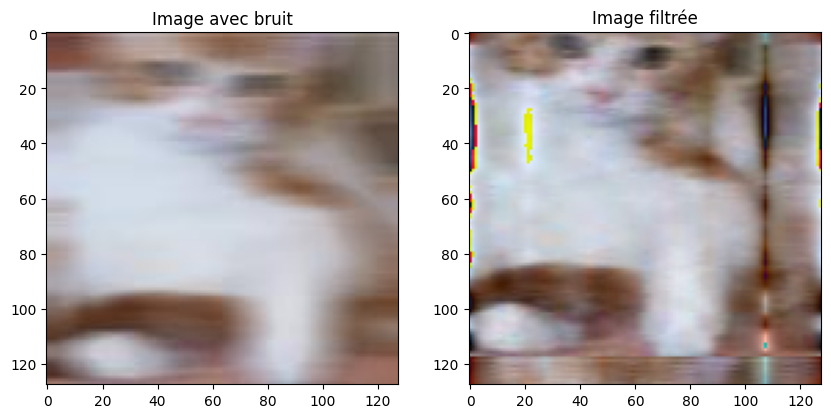

In [ ]:
original_image = cv2.imread('/root/.cache/kagglehub/datasets/rawaffahadnafea/cats-and-dogs-dataset-cvproject/versions/1/dataset/training_set/cats/motion_blur/cat.9.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
restaured_image_blur = preprocess_motion_blur('/root/.cache/kagglehub/datasets/rawaffahadnafea/cats-and-dogs-dataset-cvproject/versions/1/dataset/training_set/cats/motion_blur/cat.9.jpg')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(original_image), plt.title('Image avec bruit')
plt.subplot(1, 2, 2), plt.imshow(restaured_image_blur), plt.title('Image filtrée')
plt.show()

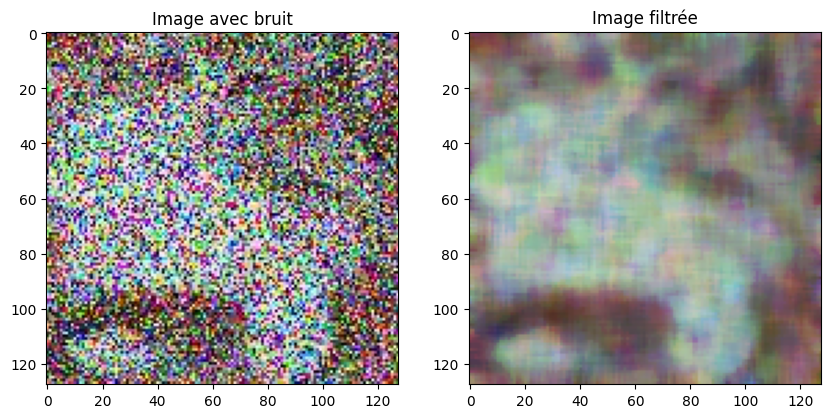

In [ ]:
original_image = cv2.imread('/root/.cache/kagglehub/datasets/rawaffahadnafea/cats-and-dogs-dataset-cvproject/versions/1/dataset/training_set/cats/salt_and_pepper_noise/cat.9.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
restaured_image_noise = original_image.copy()
for i in range(0,3):
  restaured_image_noise[:,:,i] = cv2.medianBlur(restaured_image_noise[:,:,i], 9)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(original_image), plt.title('Image avec bruit')
plt.subplot(1, 2, 2), plt.imshow(restaured_image_noise), plt.title('Image filtrée')
plt.show()

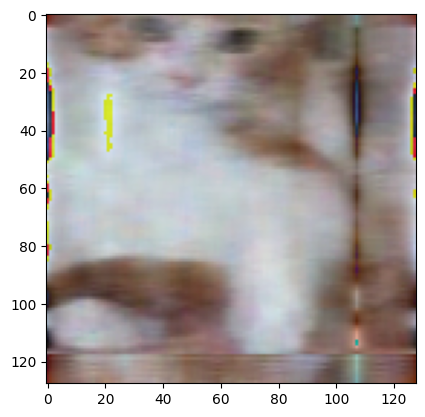

In [ ]:
blended_image = cv2.addWeighted(restaured_image_blur, 0.8, restaured_image_noise, 0.2, gamma=0)
plt.imshow(blended_image)

In [6]:
def create_psf():
  psf = np.zeros((21, 21))
  psf[10, :] = 1
  psf /= psf.sum()
  return psf

def wiener_filter(img, psf, k=0.03):
    img_fft = np.fft.fft2(img)
    psf_fft = np.fft.fft2(psf, img.shape)
    psf_fft_conj = np.conj(psf_fft)
    numerator = psf_fft_conj * img_fft
    denominator = (psf_fft * psf_fft_conj) + k
    result = np.abs(np.fft.ifft2(numerator / denominator))
    return result

def preprocess_motion_blur(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 128))
  for i in range(0,3):
    img[:,:,i] = wiener_filter(img[:,:,i], create_psf())
  return img

def preprocess_salt_pepper_noise(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 128))
  for i in range(0,3):
    img[:,:,i] = cv2.medianBlur(img[:,:,i], 9)
  return img

def load_images_from_folder(folder):
  folder_path = os.path.join(path, folder)
  dataset = []
  classes = {'cats' : 0, 'dogs' : 1}

  for label_name, label in classes.items():
    class_path = os.path.join(folder_path, label_name)

    # motion_blur ou salt_and_pepper_noise
    motion_blur_path = os.path.join(class_path, 'motion_blur')
    salt_and_pepper_noise_path = os.path.join(class_path, 'salt_and_pepper_noise')
    for file in os.listdir(motion_blur_path):
      # 128x128 .jpg
      file_blur_path = os.path.join(motion_blur_path, file)
      file_salt_pepper_path = os.path.join(salt_and_pepper_noise_path, file)

      image_blur = preprocess_motion_blur(file_blur_path) # Image filtrée
      image_salt_pepper_noise = preprocess_salt_pepper_noise(file_salt_pepper_path) # Image filtrée

      blended_image = cv2.addWeighted(image_blur, 0.8, image_salt_pepper_noise, 0.2, gamma=0)
      dataset.append((blended_image, label))
      #dataset.append((image_blur, label))
      #dataset.append((image_salt_pepper_noise, label))

  return dataset

In [7]:
data_1 = load_images_from_folder('training_set')
data_2 = load_images_from_folder('test_set')

In [8]:
SEED = 666
torch.manual_seed(SEED)
im_size = 128

class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_transform = transforms.Compose([
    ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.05, 0.1), ratio=(0.5, 1), value=0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train, val = train_test_split(data_1, test_size=0.1, random_state=SEED)

train_dataset = CustomDataset(train, transform=train_transform)
val_dataset = CustomDataset(val, transform=val_test_transform)
test_dataset = CustomDataset(data_2, transform=val_test_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

7200 800 2000


In [ ]:
val_dataset[0]

(tensor([[[-0.0801, -0.1486, -0.1999,  ..., -0.5767, -0.5424, -0.5082],
          [-0.0972, -0.1486, -0.1828,  ..., -0.5767, -0.5424, -0.5082],
          [-0.0972, -0.1314, -0.1486,  ..., -0.5424, -0.5253, -0.5082],
          ...,
          [-0.1828, -0.2171, -0.2684,  ..., -0.4397, -0.4054, -0.4054],
          [-0.1999, -0.2342, -0.2856,  ..., -0.4568, -0.4397, -0.4397],
          [-0.2856, -0.3027, -0.3369,  ..., -0.4739, -0.4739, -0.5082]],
 
         [[ 0.0826,  0.0126, -0.0574,  ..., -0.3550, -0.3375, -0.3025],
          [ 0.0651,  0.0126, -0.0224,  ..., -0.3550, -0.3550, -0.3200],
          [ 0.0651,  0.0301,  0.0126,  ..., -0.3200, -0.3375, -0.3025],
          ...,
          [-0.0574, -0.0574, -0.0574,  ..., -0.2850, -0.2325, -0.1975],
          [-0.0399, -0.0574, -0.0749,  ..., -0.3200, -0.2500, -0.2150],
          [-0.0924, -0.1099, -0.1275,  ..., -0.3375, -0.2850, -0.2500]],
 
         [[-0.2532, -0.2881, -0.3230,  ..., -0.3927, -0.4275, -0.4624],
          [-0.2707, -0.3055,

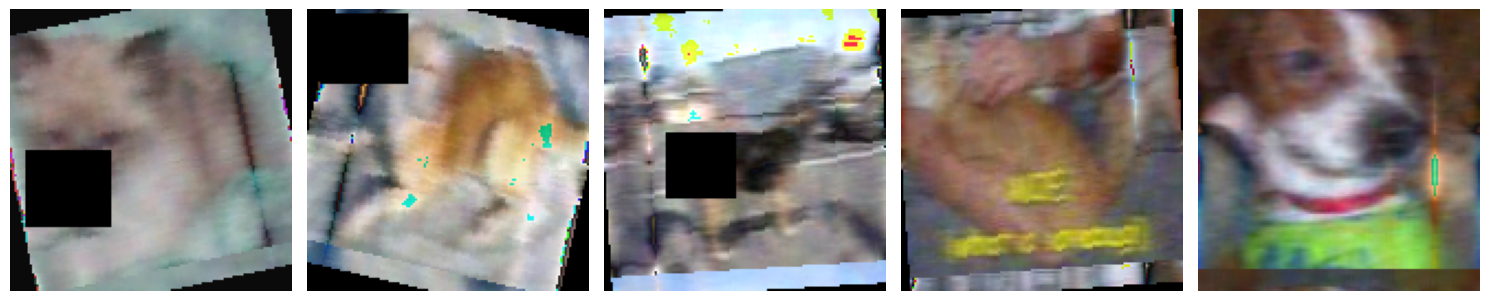

In [ ]:
images, labels = next(iter(train_loader))

images = images.numpy()

fig, axes = plt.subplots(1, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    images[i]
    img = images[i]
    img[0] = img[0] * 0.229 + 0.485
    img[1] = img[1] * 0.224 + 0.456
    img[2] = img[2] * 0.225 + 0.406
    img = img.transpose(1, 2, 0)  # Convertir de (C, H, W) à (H, W, C)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()

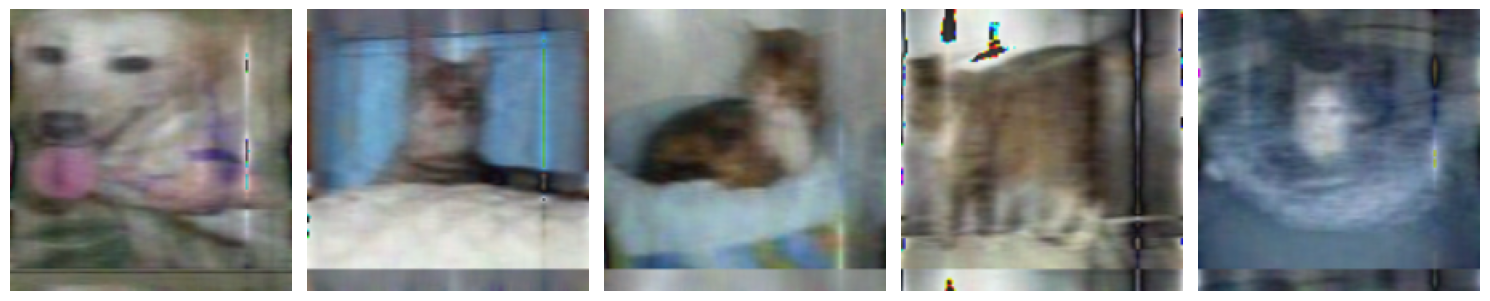

In [ ]:
images, labels = next(iter(val_loader))

images = images.numpy()

fig, axes = plt.subplots(1, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    images[i]
    img = images[i]
    img[0] = img[0] * 0.229 + 0.485
    img[1] = img[1] * 0.224 + 0.456
    img[2] = img[2] * 0.225 + 0.406
    img = img.transpose(1, 2, 0)  # Convertir de (C, H, W) à (H, W, C)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()

# Modeling

## 1

In [10]:
all_pretrained_models = timm.list_models(pretrained=True)
convnext_models = [model for model in all_pretrained_models if "convnextv2" in model]
print(convnext_models)

['convnextv2_atto.fcmae', 'convnextv2_atto.fcmae_ft_in1k', 'convnextv2_base.fcmae', 'convnextv2_base.fcmae_ft_in1k', 'convnextv2_base.fcmae_ft_in22k_in1k', 'convnextv2_base.fcmae_ft_in22k_in1k_384', 'convnextv2_femto.fcmae', 'convnextv2_femto.fcmae_ft_in1k', 'convnextv2_huge.fcmae', 'convnextv2_huge.fcmae_ft_in1k', 'convnextv2_huge.fcmae_ft_in22k_in1k_384', 'convnextv2_huge.fcmae_ft_in22k_in1k_512', 'convnextv2_large.fcmae', 'convnextv2_large.fcmae_ft_in1k', 'convnextv2_large.fcmae_ft_in22k_in1k', 'convnextv2_large.fcmae_ft_in22k_in1k_384', 'convnextv2_nano.fcmae', 'convnextv2_nano.fcmae_ft_in1k', 'convnextv2_nano.fcmae_ft_in22k_in1k', 'convnextv2_nano.fcmae_ft_in22k_in1k_384', 'convnextv2_pico.fcmae', 'convnextv2_pico.fcmae_ft_in1k', 'convnextv2_tiny.fcmae', 'convnextv2_tiny.fcmae_ft_in1k', 'convnextv2_tiny.fcmae_ft_in22k_in1k', 'convnextv2_tiny.fcmae_ft_in22k_in1k_384']


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
model = timm.create_model('convnextv2_base.fcmae_ft_in1k', pretrained=True)
print(model)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), strid

In [28]:
model.head.fc = nn.Linear(1024,2)

for param in model.parameters():
    param.requires_grad = False

for param in list(model.parameters())[-200:]:
    param.requires_grad = True

In [29]:
summary(model, input_size=(1, 3, im_size, im_size))

Layer (type:depth-idx)                                       Output Shape              Param #
ConvNeXt                                                     [1, 2]                    --
├─Sequential: 1-1                                            [1, 128, 32, 32]          --
│    └─Conv2d: 2-1                                           [1, 128, 32, 32]          (6,272)
│    └─LayerNorm2d: 2-2                                      [1, 128, 32, 32]          (256)
├─Sequential: 1-2                                            [1, 1024, 4, 4]           --
│    └─ConvNeXtStage: 2-3                                    [1, 128, 32, 32]          --
│    │    └─Identity: 3-1                                    [1, 128, 32, 32]          --
│    │    └─Sequential: 3-2                                  [1, 128, 32, 32]          (418,176)
│    └─ConvNeXtStage: 2-4                                    [1, 256, 16, 16]          --
│    │    └─Sequential: 3-3                                  [1, 256, 16, 16]   

## 2

In [13]:
def train(model, loader, historical_loss, historical_acc):
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0
  for images, labels in loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()

    train_loss+=loss.item()
  train_loss = train_loss/len(loader)
  train_acc = 100 * correct/total
  historical_loss.append(train_loss)
  historical_acc.append(train_acc)

def evaluation(model, loader, historical_loss, historical_acc):
  model.eval()
  eval_loss = 0.0
  correct = 0
  total = 0
  for images, labels in loader:
    with torch.no_grad():
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()

      eval_loss+=loss.item()
  eval_loss = eval_loss/len(loader)
  eval_acc = 100 * correct/total
  historical_loss.append(eval_loss)
  historical_acc.append(eval_acc)

In [30]:
model = model.to(device)

params_to_update = list(model.parameters())[-200:]

epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params_to_update, lr=5e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

training_loss = []
validation_loss = []
training_acc = []
validation_acc = []


In [31]:
for epoch in range(epochs):
  current_lr = scheduler.get_last_lr()[0]
  train(model, train_loader, training_loss, training_acc)
  evaluation(model, val_loader, validation_loss, validation_acc)
  print(f"Epoch [{epoch+1}/{epochs}]".center(50, "-"))
  print(f"{'Metric':<20}{'Training':<15}{'Validation':<15}")
  print(f"{'Loss':<20}{training_loss[-1]:<15.4f}{validation_loss[-1]:<15.4f}")
  print(f"{'Accuracy':<20}{training_acc[-1]:<15.4f}{validation_acc[-1]:<15.4f}")
  print(f"{'Learning Rate':<20}{current_lr:.6f}")
  print(f"{'-' * 50}")
  scheduler.step()

  model_name =  str(epoch+1) + "_" + model.__class__.__name__+ "_" + str(im_size) + ".pth"
  torch.save(model.state_dict(), model_name)
  print(f"Saving {model_name}")
  print("")

-------------------Epoch [1/20]-------------------
Metric              Training       Validation     
Loss                0.4583         0.2636         
Accuracy            77.2361        88.6250        
Learning Rate       0.000500
--------------------------------------------------
Saving 1_ConvNeXt_128.pth

-------------------Epoch [2/20]-------------------
Metric              Training       Validation     
Loss                0.3124         0.2327         
Accuracy            86.0972        90.8750        
Learning Rate       0.000497
--------------------------------------------------
Saving 2_ConvNeXt_128.pth

-------------------Epoch [3/20]-------------------
Metric              Training       Validation     
Loss                0.2452         0.2613         
Accuracy            89.7361        89.5000        
Learning Rate       0.000488
--------------------------------------------------
Saving 3_ConvNeXt_128.pth

-------------------Epoch [4/20]-------------------
Metric          

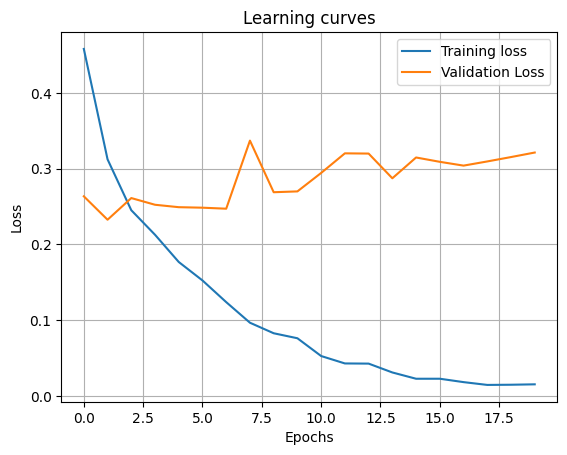

In [32]:
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Learning curves")
plt.grid()
plt.legend()
plt.show()

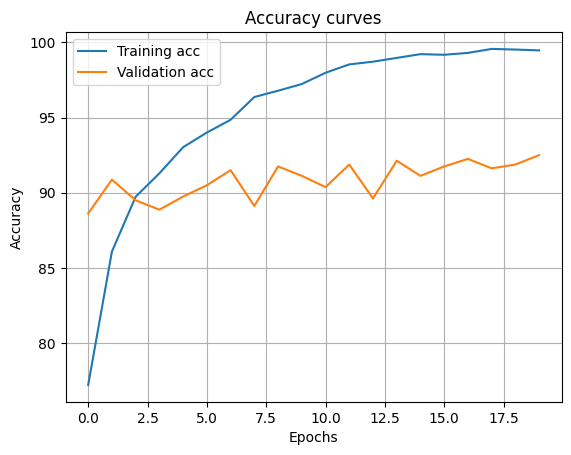

In [33]:
plt.plot(training_acc, label='Training acc')
plt.plot(validation_acc, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy curves")
plt.grid()
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('20_ConvNeXt_128.pth'))


### Validation

In [38]:
label_true = []
label_pred = []
probas_list = []

images_list = []  # Pour stocker les images à afficher
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs, pred_labs = torch.max(torch.softmax(outputs, dim=1), dim=1)

        probas_list.extend(probs.cpu().numpy())
        label_true.extend(labels.cpu().numpy())
        label_pred.extend(pred_labs.cpu().numpy())

        images_list.extend(images.cpu().numpy())

report = classification_report(label_true,label_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8974    0.9567    0.9261       393
           1     0.9554    0.8943    0.9239       407

    accuracy                         0.9250       800
   macro avg     0.9264    0.9255    0.9250       800
weighted avg     0.9269    0.9250    0.9250       800



### Test

In [39]:
label_true = []
label_pred = []
probas_list = []

images_list = []  # Pour stocker les images à afficher
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs, pred_labs = torch.max(torch.softmax(outputs, dim=1), dim=1)

        probas_list.extend(probs.cpu().numpy())
        label_true.extend(labels.cpu().numpy())
        label_pred.extend(pred_labs.cpu().numpy())

        images_list.extend(images.cpu().numpy())

report = classification_report(label_true,label_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9269    0.9260    0.9265      1000
           1     0.9261    0.9270    0.9265      1000

    accuracy                         0.9265      2000
   macro avg     0.9265    0.9265    0.9265      2000
weighted avg     0.9265    0.9265    0.9265      2000



In [40]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import torch

# Stockage des probabilités et des labels réels
label_true = []
probas_list = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilités pour la classe positive

        probas_list.extend(probs.cpu().numpy())
        label_true.extend(labels.cpu().numpy())

# Convertir en tableaux NumPy pour l'optimisation
probas_array = np.array(probas_list)
label_true_array = np.array(label_true)

# Balayage des seuils pour trouver le meilleur
thresholds = np.linspace(0.1, 0.9, 50)  # Seuils entre 0.1 et 0.9
best_threshold = 0.5
best_accuracy = 0.0

for threshold in thresholds:
    preds = (probas_array > threshold).astype(int)  # Appliquer le seuil
    acc = accuracy_score(label_true_array, preds)  # Calcul de l'accuracy
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold

print(f"Meilleur seuil : {best_threshold:.2f}, Meilleure accuracy : {best_accuracy:.4f}")

# Rapport de classification avec le seuil optimal
final_preds = (probas_array > best_threshold).astype(int)
print(classification_report(label_true_array, final_preds, digits = 4))

Meilleur seuil : 0.34, Meilleure accuracy : 0.9270
              precision    recall  f1-score   support

           0     0.9348    0.9180    0.9263      1000
           1     0.9194    0.9360    0.9277      1000

    accuracy                         0.9270      2000
   macro avg     0.9271    0.9270    0.9270      2000
weighted avg     0.9271    0.9270    0.9270      2000

